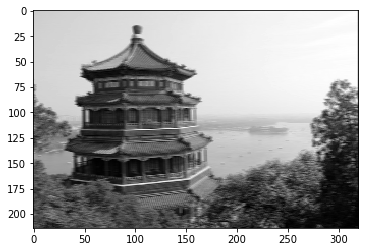

In [8]:

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_sample_image

# Load sample images.... right now the dtype of these images is uint8(427x640)
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape


# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()

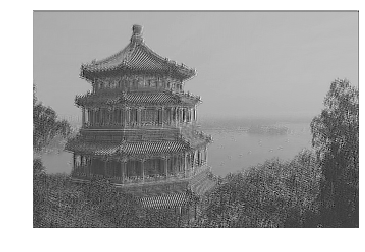

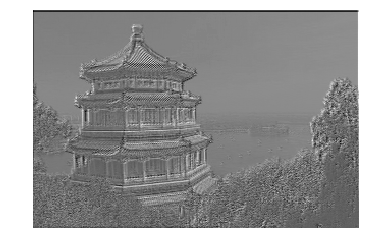

IndexError: index 1 is out of bounds for axis 0 with size 1

In [28]:


def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")


    
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()



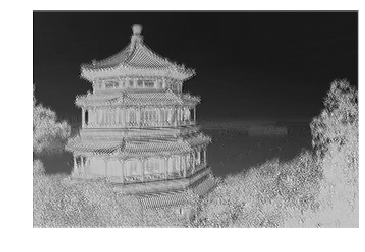

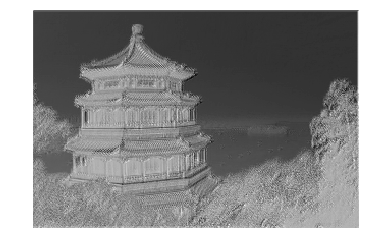

In [32]:
#using tf.layers.conv2d():

tf.reset_default_graph()

china = load_sample_image("china.jpg")
china_ds = np.array(china, dtype=np.float32).reshape(1,427,640,3)
batch_size, height, width, channels = china_ds.shape

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)   #(None, height, width, channels)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2], padding="SAME")

init = tf.global_variables_initializer()


with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: china_ds})
    
for feature_map_index in (0, 1):
        plot_image(output[0, :, :, feature_map_index])
        plt.show()

In [4]:
#valid vs same padding
import numpy as np
import tensorflow as tf

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[184.]
   [389.]]]]
SAME:
 [[[[143.]
   [348.]
   [204.]]]]


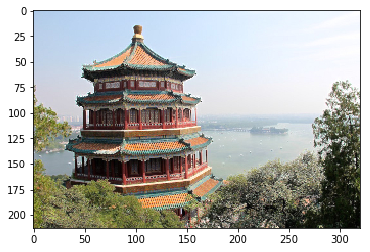

In [9]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()

# #original image is twice the size
# plt.imshow(china.astype(np.uint8))  # plot the output for the 1st image
# plt.show()

In [33]:


height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()



Instructions for updating:
Use keras.layers.dense instead.


In [34]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Last batch accuracy: 0.97 Test accuracy: 0.9792
1 Last batch accuracy: 0.99 Test accuracy: 0.9845
2 Last batch accuracy: 1.0 Test accuracy: 0.9853
3 Last batch accuracy: 1.0 Test accuracy: 0.9878
4 Last batch accuracy: 0.99 Test accuracy: 0.9871
5 Last batch accuracy: 1.0 Test accuracy: 0.987
6 Last batch accuracy: 1.0 Test accuracy: 0.9886
7 Last batch accuracy: 1.0 Test accuracy: 0.9893
8 Last batch accuracy: 1.0 Test accuracy: 0.9905
9 Last batch accuracy: 1.0 Test accuracy: 0.9866


In [36]:
#-------------exercise question------------------------

import tensorflow as tf

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1_drop, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dropout instead.


In [40]:
#the followig os all the graphkeys.global_variables
# [<tf.Variable 'hidden1/kernel:0' shape=(784, 300) dtype=float32_ref>, 
# <tf.Variable 'hidden1/bias:0' shape=(300,) dtype=float32_ref>, 
# <tf.Variable 'hidden2/kernel:0' shape=(300, 50) dtype=float32_ref>, 
# <tf.Variable 'hidden2/bias:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'hidden3/kernel:0' shape=(50, 50) dtype=float32_ref>, <tf.Variable 'hidden3/bias:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'hidden4/kernel:0' shape=(50, 20) dtype=float32_ref>, <tf.Variable 'hidden4/bias:0' shape=(20,) dtype=float32_ref>, <tf.Variable 'outputs/kernel:0' shape=(20, 10) dtype=float32_ref>, <tf.Variable 'outputs/bias:0' shape=(10,) dtype=float32_ref>]


def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}


def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

n_epochs = 1000
batch_size = 50
iteration = 0

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            iteration += 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_valid, y: y_valid})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print("Epoch {}, last batch accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_batch * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")

Epoch 0, last batch accuracy: 96.0000%, valid. accuracy: 98.2800%, valid. best loss: 0.058537
Epoch 1, last batch accuracy: 98.0000%, valid. accuracy: 98.6200%, valid. best loss: 0.047057
Epoch 2, last batch accuracy: 100.0000%, valid. accuracy: 98.7000%, valid. best loss: 0.039444
Epoch 3, last batch accuracy: 96.0000%, valid. accuracy: 98.8800%, valid. best loss: 0.036948
Epoch 4, last batch accuracy: 100.0000%, valid. accuracy: 99.0600%, valid. best loss: 0.033859
Epoch 5, last batch accuracy: 100.0000%, valid. accuracy: 99.0600%, valid. best loss: 0.033859
Epoch 6, last batch accuracy: 98.0000%, valid. accuracy: 98.9600%, valid. best loss: 0.033859
Epoch 7, last batch accuracy: 98.0000%, valid. accuracy: 98.9800%, valid. best loss: 0.033859
Epoch 8, last batch accuracy: 100.0000%, valid. accuracy: 99.0800%, valid. best loss: 0.033859
Epoch 9, last batch accuracy: 100.0000%, valid. accuracy: 99.0800%, valid. best loss: 0.033859
Epoch 10, last batch accuracy: 100.0000%, valid. accura

In [ ]:
#this is the gvars
# [<tf.Variable 'conv1/kernel:0' shape=(3, 3, 1, 32) dtype=float32_ref>, <tf.Variable 'conv1/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv2/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'conv2/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'fc1/kernel:0' shape=(12544, 128) dtype=float32_ref>, <tf.Variable 'fc1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'output/kernel:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'output/bias:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'train/beta1_power:0' shape=() dtype=float32_ref>, <tf.Variable 'train/beta2_power:0' shape=() dtype=float32_ref>, <tf.Variable 'conv1/kernel/Adam:0' shape=(3, 3, 1, 32) dtype=float32_ref>, <tf.Variable 'conv1/kernel/Adam_1:0' shape=(3, 3, 1, 32) dtype=float32_ref>, <tf.Variable 'conv1/bias/Adam:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv1/bias/Adam_1:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv2/kernel/Adam:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'conv2/kernel/Adam_1:0' shape=(3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'conv2/bias/Adam:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv2/bias/Adam_1:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'fc1/kernel/Adam:0' shape=(12544, 128) dtype=float32_ref>, <tf.Variable 'fc1/kernel/Adam_1:0' shape=(12544, 128) dtype=float32_ref>, <tf.Variable 'fc1/bias/Adam:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'fc1/bias/Adam_1:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'output/kernel/Adam:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'output/kernel/Adam_1:0' shape=(128, 10) dtype=float32_ref>, <tf.Variable 'output/bias/Adam:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'output/bias/Adam_1:0' shape=(10,) dtype=float32_ref>]



#this is the result of making dic for gvars
# {'conv1/kernel': array([[[[ 0.08095258,  0.03851599,  0.09064078,  0.05826566,
#            0.05334982, -0.06896362,  0.04053903, -0.03598565,
#            0.06232554, -0.13142724, -0.02157933,  0.01679535,
#           -0.06539129, -0.03280119, -0.01045892,  0.11544909,
#            0.03932884, -0.13714306, -0.06619713, -0.04407164,
#           -0.02200044,  0.0159767 ,  0.11550568,  0.12750764,
#           -0.01053497,  0.04151094, -0.12890413,  0.12399898,
#            0.09997471, -0.13116841,  0.0299003 ,  0.09984465]],

#         [[ 0.02350314, -0.04862109,  0.08658867, -0.1354567 ,
#            0.07186933,  0.11053027, -0.07705504, -0.09646299,
#           -0.11409211, -0.07224117, -0.0675189 , -0.11604219,
#           -0.0527346 , -0.03171503,  0.01799665,  0.12479599,
#            0.01923782,  0.09817784, -0.05815359, -0.12632345,
#           -0.00773743,  0.0817097 ,  0.05098869, -0.03663344,
#           -0.01985209, -0.13788866, -0.04987448,  0.04039402,
#            0.12839778,  0.13935052, -0.11596293,  0.13301237]],

#         [[-0.02572574, -0.0281756 , -0.09060065,  0.09541707,
#           -0.04826079,  0.06659344, -0.01388863, -0.01072551,
#           -0.01092488,  0.04755889,  0.06722249, -0.13250181,
#           -0.07034236,  0.00874867, -0.11253363,  0.0209052 ,
#            0.06536235, -0.03995334, -0.05774038,  0.06520399,
#            0.09202728, -0.00319633, -0.06693093, -0.09016687,
#            0.0748159 , -0.12326548, -0.04562005, -0.0042841 ,
#           -0.07598145,  0.06026644, -0.04540148,  0.06354429]]],


#        [[[ 0.07689045, -0.10848664,  0.05612436, -0.0305514 ,
#           -0.03697617, -0.0625622 , -0.07037029, -0.02230489,
#           -0.11771958,  0.03178105, -0.09236561,  0.10594007,
#            0.05758707, -0.05628325, -0.07785451, -0.07255104,
#           -0.12276896,  0.08779249, -0.10678803,  0.12731339,
#            0.07488611, -0.01974778,  0.13462235, -0.07285267,
#            0.12689875,  0.07081825,  0.03064053, -0.03125653,
#           -0.0514807 , -0.02978901,  0.06036189, -0.03079624]],

#         [[ 0.10879053,  0.08608831,  0.01855664,  0.07141387,
#            0.0360872 , -0.04180719,  0.00239672,  0.02976854,
#           -0.03636204,  0.05747344, -0.13642682, -0.04543642,
#           -0.03264619, -0.11903156,  0.08444479, -0.11558238,
#           -0.06061853, -0.04201915,  0.13690297, -0.0403501 ,
#            0.11740573,  0.08448209, -0.00720069,  0.01852082,
#            0.13333623, -0.0616833 ,  0.10514422,  0.04658967,
#           -0.05867153,  0.01872973, -0.04758155,  0.09516416]],

#         [[-0.0078074 ,  0.0776913 , -0.02123384, -0.05671335,
#           -0.14098649,  0.03612089,  0.10397664, -0.10572844,
#           -0.01108696, -0.13809454, -0.06601207,  0.12234713,
#            0.03086723,  0.03126568,  0.10866229, -0.11139484,
#            0.06147364,  0.08738089,  0.06454661,  0.12627228,
#           -0.13266455, -0.05283484,  0.01341875,  0.12697019,
#            0.12176795, -0.00589897,  0.01885462,  0.11532964,
#           -0.10412174, -0.00394116, -0.08191371,  0.13267605]]],


#        [[[-0.11454386,  0.13689832, -0.01485848,  0.08886743,
#            0.07893975, -0.02603734,  0.13886134,  0.00960988,
#           -0.11812717,  0.04352731, -0.06424668, -0.00852643,
#           -0.02036145,  0.11162992,  0.0841869 , -0.12059075,
#            0.10282592,  0.08771318,  0.10399029, -0.02810762,
#            0.11570539,  0.02545711,  0.11334912,  0.00201158,
#            0.12389921,  0.07589257,  0.11906017,  0.08749403,
#           -0.1311063 ,  0.08590692, -0.03267462, -0.07260062]],

#         [[ 0.08698314,  0.0659309 ,  0.13307162, -0.05111987,
#           -0.0862667 ,  0.14121275,  0.0071972 , -0.14160854,
#            0.05643673,  0.04889907,  0.08098681,  0.10629575,
#           -0.00072403,  0.00211501,  0.01663384, -0.07852884,
#            0.04470131,  0.08385321, -0.12883683, -0.0164502 ,
#           -0.00978023, -0.12671311, -0.10028488, -0.05822533,
#            0.04570332,  0.03388348, -0.03638013,  0.04707056,
#           -0.05339462, -0.02859807,  0.09144598,  0.0868804 ]],

#         [[ 0.11864023, -0.11439791, -0.06309529, -0.1378654 ,
#           -0.01513958,  0.0763305 , -0.08923957, -0.08466878,
#           -0.1114898 , -0.01028141,  0.09618171, -0.13930385,
#           -0.10403343,  0.09926097,  0.03417827,  0.10083871,
#           -0.04165615, -0.06416514, -0.02007943, -0.03901616,
#            0.05159822, -0.09153663, -0.01963832,  0.01826887,
#           -0.00102068,  0.09629847,  0.00474067, -0.02550676,
#            0.01131251,  0.07616252,  0.03310065,  0.0155973 ]]]],
#       dtype=float32), 'conv1/bias': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
#       dtype=float32), 'conv2/kernel': array([[[[-5.8062732e-02,  6.4602122e-03, -4.9525499e-02, ...,
#            1.4039241e-02, -6.4972818e-02, -6.7561686e-02],
#          [-1.5784144e-02, -3.0652508e-03, -7.3950075e-02, ...,
#           -4.5186739e-02, -7.7346906e-02,  2.8599501e-03],
#          [ 4.5564242e-02,  2.5704168e-02, -5.6475502e-02, ...,
#           -4.3328684e-02, -5.8892250e-02,  3.8824536e-02],
#          ...,
#          [-7.7209949e-02, -2.1848701e-02, -2.3723505e-02, ...,
#           -4.5136552e-02,  2.4354018e-02,  7.4065529e-02],
#          [ 2.4849854e-02, -6.3680157e-02, -5.1411986e-02, ...,


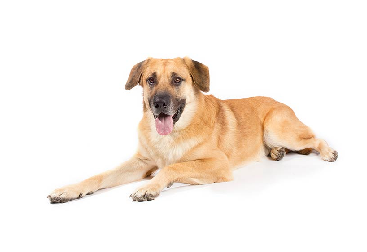

In [150]:
import os

width = 299
height = 299
channels = 3

import matplotlib.image as mpimg
test_image = mpimg.imread(os.path.join("images","cnn","dog.jpg"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

#need to scale this to -1.0 to 1.0 to be used in inception module
test_image = 2 * test_image - 1

In [130]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
#     If exist_ok is False (the default), an FileExistsError is raised if the target directory already exists.
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [131]:
#  urllib.request.urlretrieve(url, filename=None, reporthook=None, data=None)
#  Copy a network object denoted by a URL to a local file. If the URL points to a local file, the object will not be copied unless filename is supplied. Return a tuple (filename, headers) where filename is the local file name under which the object can be found, and headers is whatever the info() method of the object returned by urlopen() returned (for a remote object). Exceptions are the same as for urlopen().

# #  The second argument, if present, specifies the file location to copy to enerated name). 
# The third argument, if present, is a callable that will be called once on establishment of the network 
# connection and once after each block read thereafter. The callable will be passed three arguments; 
# a count of blocks transferred so far, a block size in bytes, and the total size of the file.

In [132]:
fetch_pretrained_inception_v3()

import re

# ^The end$   exact string match (starts and ends with The end)
# abc*        matches a string that has ab followed by zero or more c 
# a(bc)*      matches a string that has a followed by zero or more copies of the sequence bc
# abc+        matches a string that has ab followed by one or more c
# \d         matches a single character that is a digit
# \s         matches a whitespace character (includes tabs and line breaks)
# m (multi-line) when enabled ^ and $ will match the start and end of a line, instead of the whole string
# (.*) matches any character (except for line terminators)


CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)  #

def load_class_names():
    path = os.path.join("datasets", "inception", "imagenet_class_names.txt")
    with open(path, encoding="utf-8") as f:
        content = f.read()
#         return content
        return CLASS_NAME_REGEX.findall(content)

In [133]:
load_class_names()
# CLASS_NAME_REGEX.findall('n564 this is anaum. \nn87 i wonder if you know')

class_names = ["background"] + load_class_names()

class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

In [134]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

#right now, saving the already pretrained model checkpoint
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    # 

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
[[0. 0. 0. ... 0. 0. 0.]]


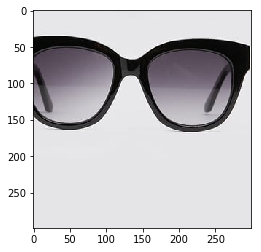

In [195]:
test_image = mpimg.imread(os.path.join("images","cnn","glasses.jpg"))[:, :, :channels]
test_image = test_image[500:299+500,150:299+150,:]
plt.imshow(test_image)


X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})
    print(predictions_val)   #out probs for all the classes i.e. 1001



In [196]:
most_likely_class_index = np.argmax(predictions_val)

class_names[most_likely_class_index]




448

In [262]:
#dontunderstand how this works
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])

#this doing the same as before
see = reversed(np.argsort(predictions_val[0])[-5:])

for i in see:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

# binoculars, field glasses, opera glasses: 87.31%
# flatworm, platyhelminth: 12.60%
# clog, geta, patten, sabot: 0.09%
# kimono: 0.00%
# web site, website, internet site, site: 0.00%


binoculars, field glasses, opera glasses: 87.31%
flatworm, platyhelminth: 12.60%
clog, geta, patten, sabot: 0.09%
kimono: 0.00%
web site, website, internet site, site: 0.00%


In [263]:
import sys
import tarfile
from six.moves import urllib

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)


In [264]:
fetch_flowers()

flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
#trying to remove licence.txt by checking it a certain dirname is a folder
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

Downloading: 100%

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [286]:
# A defaultdict works exactly like a normal dict, but it is initialized with a function (“default factory”) that takes no arguments and provides the default value for a nonexistent key.
##### from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

for paths in image_paths.values():
    paths.sort()

Class: daisy
131
132
133


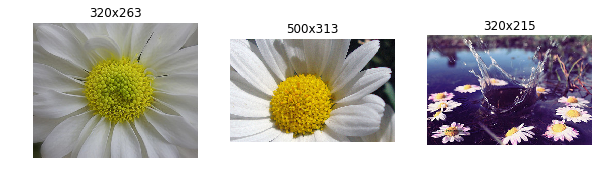

Class: dandelion
131
132
133


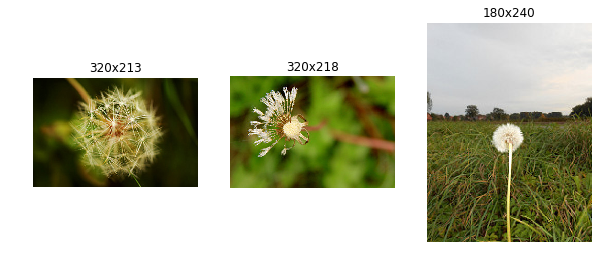

Class: roses
131
132
133


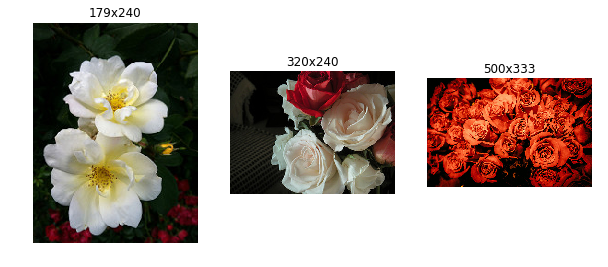

Class: sunflowers
131
132
133


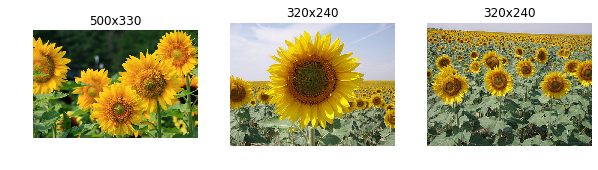

Class: tulips
131
132
133


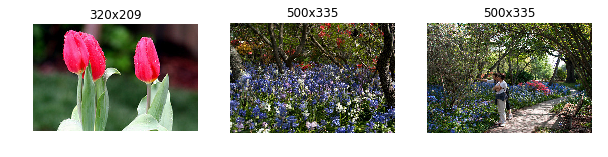

In [289]:
#checking image from each class
import matplotlib.image as mpimg

n_examples_per_class = 3

for flower_class in flower_classes:
    print("Class:", flower_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        print(100 + n_examples_per_class * 10 + index + 1)
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

In [ ]:
#data augumentation

from skimage.transform import resize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    # The resize function of scikit-image will automatically transform the image to floats ranging from 0.0 to 1.0
    image = resize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as 32-bit floats:
    return image.astype(np.float32)
